# Mock Data for Compressed Matrices



### taken from `https://github.com/bamler-lab/webgl-entropy-coding`

## File Format Specification

We store $K$ compressed matrices $W_0, \dots, W_{K-1}$, and a single uncompressed vector $v_0$.

- For $k \in \{0, \ldots, K-1\}$, the matrix $W_k$ has dimension $N_{k+1} \times N_k$.
- The vector $v_0$ has dimension $N_0$.

Thus, the statement $v_K := W_{K-1} W_{K-2} \ldots W_0 v_0$ denotes a valid sequence of matrix-vector multiplications with matching dimensions, resulting in a vector $v_K$ with dimension $N_K$.

### Overall Container Format

The overall file layout is structured as follows:

$
  \begin{array}{|r||c|c|c|c|c|c|c|c|c|}
      \hline
      \text{data:} & K   &\texttt{result\_hash} & S_\text{max} & N_0 &  v_0     & \texttt{pad} & W_0              & W_1              & \cdots & W_{K-1} \\ \hline
      \text{type:} & u32 & u32          & u32 & u32& i8[N_0] & u8[3 - ((N_0 + 3) \operatorname{mod} 4)]         & \text{see below} & \text{see below} & \cdots & \text{see below}   \\ \hline
  \end{array}
$

Here,

- `u<X>` (e.g., $u8$, $u32$) denotes an unsigned $X$-bit integer value;
- `i<X>` (e.g., $i8$) denotes a signed $X$-bit integer value;
- $\texttt{result\_hash}$ contains a 32-bit hash of the final result vector to verify correctness in the kernel
- all numbers are stored in little endian byte order;
- `{u, i}<X>[size]`, i.e., a type followed by braces (e.g., $i8[N_0]$) denotes a densely packed array of `size` elements of the same type;
- $S_\text{max}$ is the maximum size of the compressed representation (see below) of any of the involved matrices $W_0, \ldots, W_{K-1}$, including matrix headers (as described below), measured in units of 16 bit (2 byte).
- `pad` contains either 0, 1, 2, or 3 bytes whose values will be ignored by the decoder;
  its length $l_\text{pad} \in \{0,1,2,3\}$ is determined such that $N_0 + l_\text{pad}$ is an integer multiple of $4$, so that the subsequent fields can be 32-bit aligned;
- the compressed representation of the matrices $W_0, \ldots, W_{K-1}$ is detailed below.

### Matrix Container Format

In the above overall container format, each matrix $W_k$ for $k\in \{0,\ldots,K-1\}$ is stored in the following layout:

$
  \begin{array}{|r||c|c|c|c|c|c|c|c|c|c|}
      \hline
      \text{data:} & N_{k+1} & N_{k} & \delta & \texttt{cursors} & \texttt{payload\_size} & \hat{w}_\text{min} & |G| & \texttt{cdf} & \texttt{pad} & \texttt{ppf}& \texttt{payload} \\ \hline
      \text{type:} & u32   & u32     & f32    & u32[N_{k+1}]     & u32                    & i8                 & u8  & u8[|G| + 1]  &  u8[(|G|+1) \operatorname{mod} 2]     & u8[256] & u16[\texttt{payload\_size}] \\ \hline
  \end{array}
$

- ~~**TODO:**~~ maybe we should flush the coders after each matrix. The overhead is negligible (32 bit per matrix row, i.e., same as the overhead for the `cursors`)  **&#x2611;** (done in the `interrupt` method of ANSCoder, 11.09.2025)

Here,

- $\delta$ is the distance between neighboring grid points; i.e., if $\hat{W}_k \in \mathbb{Z}^{N_{k+1}\times N_k}$ is the integer representation of the decoded quantized matrix, then the true quantized matrix is $W_k = \delta \hat{W}_k$, and thus, for a vector-matrix multiplication $v_{k+1} := W_k v_k$, we have $v_{k+1} = \delta \hat{v}_{k+1}$ where $\hat{v}_{k+1} := \hat{W}_k v_k$.
- `cursors` is an array of the size of the output dimension $N_{k+1}$ which, for each matrix row, contains an offset into `payload` where additional compressed data for this matrix row (if needed) starts; offsets are measured in units of 16 bit (2 byte), and relative to the start of the `payload` field (thus, `cursors[0]` is always `0`);
- `payload_size` is the length of the `payload` field, measured in units of 16 bit (2 byte);
  since the `payload_size` field directly follows the `cursors` field, `payload_size` can be interpreted as an $(N_{k+1}+1)$-th cursor pointing to where the compressed data for an additional matrix row would start if there was one more matrix row.
  - Due to payload padding (see below), `payload_size` is always even (so that all compressed matrix structs are 32-bit aligned).
- $\hat{w}_\text{min}$ is the smallest value present in the integer representation $\hat{W}_k$ of the quantized matrix.
- $|G|$ is the grid size; we assume a uniform grid, i.e., the integer representation $\hat{W}_k$ of the quantized matrix takes only values from the range $\{\hat{w}_\text{min}, {\hat{w}_\text{min} + 1}, \ldots, {\hat{w}_\text{min} + |G| - 1}\}$.
- `cdf` is the cumulative distribution function of the entropy model in 8-bit unsigned integer representation.
  Its interpretation is that it defines a probability mass function (PMF) via $\texttt{pmf}[r] := (\texttt{cdf}[r + 1] - \texttt{cdf}[r]) \operatorname{mod} 2^8 \;\forall r \in \{0, 1, \ldots, |G|-1\}$.
  Here, the "$\operatorname{mod} 2^8$" wraps only for the last entry, $\texttt{pmf}[|G|-1] = {(0 - \texttt{cdf}[r]) \operatorname{mod} 2^8} = 2^8 - \texttt{cdf}[|G|-1]$, which is enforced by the requirements $\texttt{cdf}[|G|] = 0$ and $\texttt{cdf}[|G|-1] > 0$, see below, and the fact that $\texttt{cdf}[|G|-1] < 2^8$ since $\texttt{cdf}[|G|-1]$ is an unsigned 8-bit integer.
  The `cdf` it satisfies the following properties:
  - The first $|G|$ entries of `cdf` make up a nonincreasing sequence: `cdf[0] <= cdf[1] <= ... <= cdf[|G| - 1]`.
  - `cdf[0] = cdf[|G|] = 0`.
  - `cdf[|G| - 1] > 0` (which implies that $|G| \geq 2$ since `cdf[0] = 0`);
    thus, the entropy model must not represent a delta distribution that puts all probability mass on a single grid point;
    this requirement enables a simplification in the implementation of the ANS algorithm while anyway only affecting the pathological edge case where all matrix elements of $\hat{W}_k$ are equal.
    This pathological edge case can still be treated efficiently, e.g., by setting $|G|=2$, setting $\hat{w}_\text{min}$ to the value taken by all matrix elements, and setting $\texttt{cdf} = [0, 255, 0]$.
    With these settings, the entropy model puts almost all probability mass on the entry taken by all matrix elements and only a tiny probability mass on an irrelevant dummy grid point, resulting in a cross entropy of $\log_2(\frac{256}{255}) \approx 0.0056$ bit per matrix element.
  - If `cdf[r] = cdf[r + 1]` for some $r \in \{0, \ldots, {|G|-2}\}$, then this means that the entropy model assigns zero probability mass to the value ${\hat{w}_\text{min} + r}$, and therefore $\hat{W}_k$ must not contain any matrix entry with value ${\hat{w}_\text{min} + r}$ because this value cannot be encoded with this entropy model.
- `pad` is either nothing or a single byte with arbitrary value that should be ignored by the decoder.
  This byte is inserted if the grid size $|G|$ is even to ensure that the `payload` can be properly 16-bit aligned.
- `payload` contains the compressed data, see below.

### Compressed Bit String Representation & Decoding

We define the format of the `payload` field in the above matrix container format by specifying the decoding process.
The encoding algorithm follows from this specification as encoding is inference over a decoder.

When decoding the $k$-th matrix with dimensions $N_{k+1}\times N_k$, the decoder operates on the $N_{k+1}$ matrices independently (and thus, possibly in parallel).
All decoders need read access to the shared `cdf` of the entropy model, the shared `payload` of the compressed matrix, and a coder-specific cursor $C_i$ that gets initialized at the beginning of each matrix-decoding process from `cursor[i]` declared in the matrix container format.
A practical implementation will likely also want to create a shared `ppf` lookup table that stores the inverse of `cdf` to speed up steps 2 and 3 below.

Decoding the $i$-th row of matrix $W_k$ works as follows:

- Initialize the row's cursor $C_i \gets \texttt{cursors}[i]$, where `cursors` is a field of the matrix container format specified above.
- Initialize an unsigned 32-bit coder state $S_i \gets (\texttt{payload}[C_i] \ll 16) \;|\; \texttt{payload}[C_i+1]$, where "$\ll$" denotes left bit-shift and "$|$" denotes bitwise or.
  Thus, the 32-bit coder state $S_i$ is initialized to the concatenation of the first two 16-bit words read off the `payload` starting from the row's initial cursor.
- Increment the curser accordingly: $C_i \gets C_i + 2$.
- For each column $j \in \{0,\ldots,N_k-1\}$ (in ascending order) do:
  1. Set `quantile` ← least significant 8 bits of the coder state $S_i$
  2. Set `r` to the uniquely defined number in $\{0,\ldots,|G|-1\}$ such that `cdf[r] <= quantile < cdf[r+1]`.
  3. Set the (integer representation of the) decoded matrix element to $(\hat{W}_k)_{ij} \gets r + \hat{w}_\text{min}$.
  4. Update the coder state $S_i \gets (S_i \gg 8) \times$ `((cdf[r+1] - cdf[r]) mod 256)` + `(quantile - cdf[r])`,
     where "$\gg$" denotes left bit shift (that is _unsigned_, i.e., it fills from the right with zero bits).
  5. If $S_i < 2^{16}$ (i.e., if the 16 most significant bits of the 32-bit number $S_i$ are all zero, or, equivalently, if $(S_i \gg 16) = 0$), then:
     - Update $S_i \gets (S_i \ll 16) \;|\; \texttt{payload}[C_i]$,
       where "$\ll$" denotes left bit shift, and "$|$" denotes bitwise `or` (this update can be understood as concatenating $\texttt{payload}[C_i]$ to $S_i$ since $\texttt{payload}[C_i]$ is a 16-bit unsigned integer).
     - Increment $C_i \gets C_i + 1$.

### Encoding

A valid encoder is any program that generates a file in the format specified above such that decoding the file with the decoding algorithm specified above generates the desired (quantized) matrices $\hat{W}_0, \ldots, \hat{W}_{K-1}$.

In practice, encoding a quantized matrix $W_k$ of shape $N_{k+1} \times N_k$ can be performed as follows:

- Prepare an integer representation $\hat{W}_k \in \mathbb{Z}^{N_k \times N_{k+1}}$ of the quantized matrix and determine its minimum $\hat{w}_\text{min} := \min_{i,j} (\hat{W}_k)_{ij}$ and grid size $|G| := \max_{i,j} (\hat{W}_k)_{ij} - \hat{w}_\text{min} + 1 \ge 2$.
- Prepare a suitable `cdf` for $\hat{W}_k$.
- Initialize `reverse_payload` ← empty growable array of `u16`.
- For each row $i \in \{0,\ldots,N_{k+1}-1\}$ in _descending_ order, do (note: this could be parallelized without changing the result):
  - Initialize an unsigned 32-bit coder state $S \gets 2^{16}$.
  - For each column $j \in \{0,\ldots,N_k-1\}$ in _descending_ order, do:
    1. Set $r \gets (\hat{W}_k)_{ij} - \hat{w}_\text{min}$; (thus, $r \in \{0,\ldots, |G|-1\}$).
    2. Set `probability ← (cdf[r+1] - cdf[r]) mod 256`.
    3. If $(S \gg 24) \geq \texttt{probability}$ (i.e., if dividing $S$ by `probability` and then shifting it by 8 bit to the left would overflow its 32-bit size):
       - Push the 16 least significant bits of $S$ to the end of `reverse_payload`.
       - Update $S \gets (S \gg 16)$.
    4. Set $\texttt{quantile} \gets \texttt{cdf}[r] + (S \,\operatorname{mod}\, \texttt{probability})$;
       thus, $\texttt{quantile} \in \{0, \ldots, 255\}$.
    5. Update $S \gets (\lfloor S / \texttt{probability} \rfloor \ll 8) \;|\; \texttt{quantile}$,
       where "$\lfloor \,\cdot\,\rfloor$" denotes rounding down to an integer.
  - Push first the least significant 16 bit and then the most significant 16 bit of $S$ to the end of `reverse_payload`.
  - Set `back_cursor[i] ← length(reverse_payload)`, where length is measured in units of 16 bit.
- Obtain `payload` by reversing the order of elements in the array `reverse_payload`.
- For each $i \in \{0,\ldots,N_{k+1}-1\}$, set `cursor[i] ← length(payload) - back_cursor[i]`.
  Thus, we should have `cursor[0] = 0`.
- if `payload` has an odd length (i.e., contains an odd number of `u16`s), then append a single additional `u16` with arbitrary value (e.g., zero) to it to make it an even length.

In [30]:
import numpy as np
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import struct
import sys

## Create Random Quantized Matrices





























100%|██████████| 40/40 [00:00<00:00, 46.57it/s]


mins: [-127 -127 -127 -127 -127 -113 -127 -127 -107 -121 -119 -127 -127 -127
 -109 -127 -127 -119 -127 -123 -117 -125 -127 -127 -127 -127 -125 -127
 -123 -127 -127 -127 -119 -125 -127 -127 -117 -127 -127 -123]
maxs: [123 123 123 127 125 127 127 113 127 127 127 121 119 107 127 117 125 127
 115 127 127 127 115 125 127 125 127 117 127 125 121 113 127 127 121 127
 127 121 113 127]


 10%|█         | 4/40 [28:12<4:13:50, 423.06s/it]


Entropy in bits: 5.857737402753593


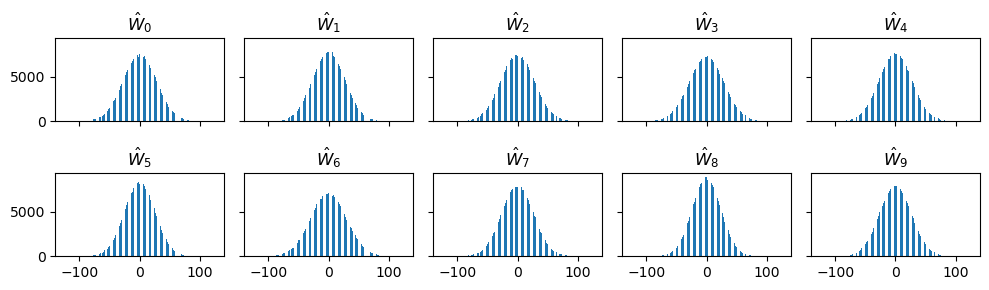

In [31]:
np.random.seed(20250310)

w = 512
sigma = 1/np.sqrt(w)
n = 40
precision = 8

entropy = 7 # upper bound of entropy 

quantized_matrices = np.empty((n,w,w), dtype=np.int8)
w_deltas = np.zeros(n)
for i in tqdm(range(n)):
    matrix = np.random.randn(w, w)* sigma
    max_value = (2**(entropy-1))-1 # for signed integer maximum value is (2**(entropy-1))-1, neglecting -2**(entropy-1)
    w_delta =  np.abs(matrix).max()/max_value  # quantize matrices to int8 grid
    w_deltas[i] = w_delta # store as weight delta
    quantized_matrices[i,...] = np.round(np.round( matrix/ w_delta ) * 127 / max_value).astype(np.int8)

print(f'mins: {quantized_matrices.min(axis=(1, 2))}')
print(f'maxs: {quantized_matrices.max(axis=(1, 2))}')

fig, axs = plt.subplots(2, 5, figsize=(10, 3), sharex=True, sharey=True, tight_layout=True)
bins = np.arange(-np.abs(quantized_matrices).max() - 0.5, np.abs(quantized_matrices).max() + 1.5)
for i, ax in enumerate(axs.flat):
    ax.hist(quantized_matrices[i ].ravel(), bins=bins)
    ax.set_title(r'$\hat{W}_{' + str(i) + r'}$')

vector = np.round(np.random.randn(w) * 4).astype(np.int8)


values, counts = np.unique(quantized_matrices[0], return_counts=True)
probs = counts/ counts.sum()
print(f"Entropy in bits: {probs @ -np.log2(probs)}")

In [32]:
def hash_int8_array(arr):
    """Simple hasher adopted from the "FxHash" rust crate.
    Not cryptographically secure, but _accidental_ collisions are very unlikely."""

    assert arr.dtype == np.int8

    hash = 0
    for byte in arr.astype(np.uint8).ravel():
        # rotate left by 5 bits
        hash = ((hash >> 27) | (hash << 5)) & 0xffff_ffff
        hash = ((hash ^ byte.item()) * 0x2722_0a95) & 0xffff_ffff

    return hash

## Calculate Result in python

In [33]:

v_delta = 1
v_int8 = vector.copy()
for i,mat in enumerate(quantized_matrices):
    # .astype(np.int32) to not overflow while accumulating
    if i==0:
        print(mat.astype(float)[:4,0])
    v_int32 = (mat.astype(float) @ v_int8.astype(float))
    
    # multiply w_deltas and v_delta to scale back to original values
    v_f32 = v_int32 * w_deltas[i] * v_delta

    # requantization to align again to  int8 
    v_delta = np.abs(v_f32).max() / 127 

    v_int8 = (v_f32 / v_delta)
    v_int8 = np.round(v_int8) # rounding for quantization

final_result = v_int8
print(list(v_int8))
result_hash = hash_int8_array(np.array(final_result,dtype=np.int8))
print(result_hash)

[ 40.  12. -38.  10.]
[-8.0, -33.0, -16.0, -86.0, -63.0, -47.0, -18.0, -11.0, -5.0, -48.0, -14.0, -14.0, -98.0, -3.0, -4.0, 78.0, 29.0, 1.0, -32.0, -4.0, -30.0, 20.0, -20.0, -17.0, -27.0, 36.0, 16.0, 71.0, -10.0, 18.0, -43.0, 18.0, -23.0, -21.0, -29.0, -5.0, 51.0, -67.0, 42.0, -40.0, -16.0, 27.0, -67.0, -60.0, 53.0, 32.0, -114.0, 9.0, 23.0, 8.0, 2.0, 0.0, 35.0, 3.0, -67.0, -62.0, -11.0, 27.0, -3.0, 48.0, -54.0, 26.0, 34.0, 31.0, -7.0, 39.0, -22.0, 38.0, -9.0, -48.0, -2.0, -46.0, -20.0, 35.0, -17.0, 13.0, -9.0, 13.0, 56.0, -3.0, -7.0, -1.0, -80.0, -35.0, 28.0, -39.0, 54.0, 2.0, 12.0, -36.0, -19.0, 42.0, 32.0, -15.0, 90.0, -40.0, -5.0, -41.0, -32.0, 24.0, 52.0, -59.0, -23.0, 66.0, 33.0, 86.0, 25.0, -42.0, 31.0, -90.0, -6.0, -36.0, -34.0, 12.0, -39.0, 18.0, -49.0, 15.0, 53.0, -12.0, 36.0, -54.0, -65.0, 46.0, 46.0, 6.0, -66.0, -24.0, 5.0, 18.0, -0.0, -42.0, 46.0, 22.0, 15.0, 5.0, 20.0, 38.0, -23.0, 19.0, -52.0, -48.0, 82.0, 32.0, 35.0, 50.0, 11.0, 21.0, 1.0, -36.0, 15.0, -33.0, -9.0, -1.0,

## Write `raw-matrices.bin` for baseline comparison
Uses the same overall container format but stores matrix elements in column major ordering

$
  \begin{array}{|r||c|c|c|c|c|c|c|c|}
      \hline
      \text{data:} & K    &  \texttt{result\_hash} & N_0 & v_0     & \texttt{pad} & W_0              & W_1              & \cdots & W_{K-1} \\ \hline
      \text{type:} & u32  & u32 & u32 & i8[N_0] & u8[3 - ((N_0 + 3) \operatorname{mod} 4)]         & \text{see below} & \text{see below} & \cdots & \text{see below}   \\ \hline
  \end{array}
$

$
  \begin{array}{|r||c|c|c|c|c|c|}
      \hline
      \text{data:} & N_{k+1} & N_{k} & \delta &    \texttt{payload} & \texttt{padding} \\ \hline
      \text{type:} & u32   & u32     & f32    &  i8[N_{k+1}N_k]  & i8[N_{k+1}N_k mod 2]  \\ \hline
  \end{array}
$ 

If the number of rows or columns is not divisible by 2 the last byte of `payload` is padded with zeros.

In [34]:
def serialize_file_header_raw(file, num_matrices, result_hash): # omitting max word count
    print(f"Num_matrices: {num_matrices}")
    file.write(struct.pack('<LL', num_matrices, result_hash))

def serialize_vector_raw(file, vec):
    print(f"len_v: {len(vec)}")
    file.write(struct.pack('<L', len(vec)))
    # whatever you system does, we like little endian
    if sys.byteorder == 'little': 
        vec.astype(np.int8).tofile(file)
    else:
        vec.astype(np.int8).byteswap().tofile(file)

    file.write(b'\0' * (3 - (len(vec) + 3) % 4))

def serialize_raw_matrix(file, matrix):

    file.write(struct.pack(
        f'<LLf',
        *matrix.shape,1.))

    if sys.byteorder == 'little': 
        matrix.flatten(order="C").astype(np.int8).tofile(file) # C for C-Style saves matrix in row major format
    else:
        matrix.flatten(order="C").astype(np.int8).byteswap().tofile(file)

    if matrix.size % 2 != 0: 
        file.write(b'\0') # padding for if matrix does not have an even amount of 


with open('raw-matrices.bin', 'wb') as file:
    serialize_file_header_raw(file, len(quantized_matrices), result_hash)
    serialize_vector_raw(file, vector)
    for matrix in quantized_matrices:
        serialize_raw_matrix(file, matrix)

Num_matrices: 40
len_v: 512


## Create Entropy Models

In [35]:
def create_entropy_model(data, precision):
    min_value = data.min().item()
    max_value = data.max().item()

    if min_value == max_value:
        # Special case: all values are the same. Due to a limitation of ANS coding, we have
        # to create a dummy extra grid point with the smallest possible nonzero probability.
        grid_size = 2
        cdf = np.array([0, (1 << precision) - 1, 1 << precision], dtype=np.uint16)
        entropy = 0
        # To avoid loss of precision, we use `log1p(x) := log(1 + x)`, and thus:
        # cross_entropy = - log2((2^p - 1) / 2^p) = - log2(1 - 1 / 2^p) = - log1p(-1 / 2^p) / log(2)
        cross_entropy = - np.log1p(-1 / (1 << precision)) / np.log(2)
    else:
        grid_size = max_value - min_value + 1
        values, counts = np.unique(data, return_counts=True)

        # Sort descendingly by `counts`.
        order = np.argsort(counts)[::-1]
        values = values[order]
        counts = counts[order]

        scale = (1 << precision) / data.size
        quantized_counts = np.maximum(1, np.round(counts * scale).astype(np.uint16))

        excess = sum(quantized_counts).item() - (1 << precision)
        if excess > 0:
            # Shave off some probability mass from the most probable entries
            assert excess <= len(counts)
            while excess > 0:
                num_reducible_entries = (quantized_counts > 1).sum()
                num_reduce = min(excess, num_reducible_entries)
                assert num_reduce > 0
                quantized_counts[:num_reduce] -= 1
                excess -= num_reduce
            quantized_counts[:excess] -= 1
        elif excess < 0:
            # Spread some probability mass to the least probable entries.
            assert -excess <=len(counts)
            quantized_counts[excess:] += 1

        assert quantized_counts.sum() == 1 << precision


        # see https://github.com/wildug/gpu-comp/wiki for a derivation
        entropy = np.log2(data.size) - (counts @ np.log2(counts)) / data.size 
        cross_entropy = precision - (counts @ np.log2(quantized_counts)) / data.size

        padded_pmf = np.zeros(grid_size + 1, dtype=np.uint16)
        for value, prob in zip(values, quantized_counts):
            padded_pmf[value - min_value + 1] = prob

        cdf = np.cumsum(padded_pmf, dtype=np.uint16)
        assert cdf[0] == 0
        assert cdf[-1] == 1 << precision

    return min_value, grid_size, cdf, entropy, cross_entropy

In [36]:
def create_ppf(cdf, p_precision= 8):
    # handcrafet for 8 bit precision (weights && probs)
    # TODO generalize to arbitrary weight and prob precisions

    ppf = np.zeros((1<<p_precision), dtype=np.uint8) # ppf is of size 2**p_prec
    # for each possible probability save its corresponding value of the cdf
    for p in range ((1<< p_precision)):
        for r in range(len(cdf)-1,0,-1):
            if (cdf[r-1] & 0xFF).astype(np.uint8) <=p:
                ppf[p]= r-1
                break
            


    # ppf[1<<p_precision] = len(cdf) -1
        

    assert ppf[-1] == len(cdf)-2 # for 8-bit integer weights
    assert ppf[0] == 0
    return ppf
            

252
256


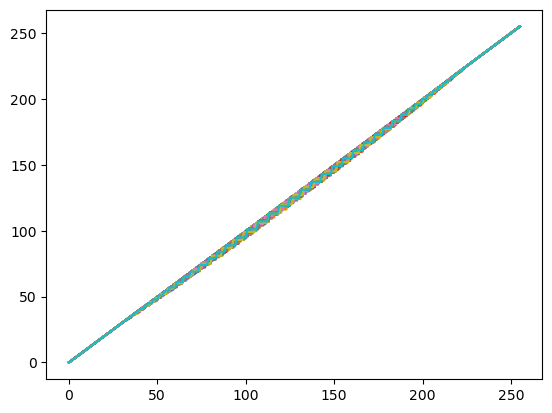

In [37]:
for i,m in enumerate(quantized_matrices):
    min_value, grid_size, cdf, entropy, cross_entropy = create_entropy_model(m, 8)
    ppf = create_ppf(cdf)


    plt.plot([cdf[w] for w in ppf], label=f"{i}")
print(len(cdf))
print(len(ppf))

## Entropy Coder

In [38]:
class AnsCoder:
    def __init__(self, precision, word_size,  compressed=[], head_size=2):
        # int head_size determines the size of the coder head as multiples of word_size bits
        self.precision = precision
        self.word_size = word_size
        self.word_mask = (1 << word_size) - 1
        self.quantile_mask = (1 << precision) - 1
        self.bulk = compressed.copy()
        self.head = 0
        self.head_size = head_size
        self.head_mask = (1 << (word_size * head_size)) - 1
        # while len(self.bulk) != 0 and (self.head >>(self.word_size)*(self.head_size-1)) == 0:
        #     self.head = ((self.head << word_size) | int(self.bulk.pop())) & self.head_mask
        if compressed == []:
            self.bulk = [0] * (head_size-1) + [1]
        if len(compressed)>= self.head_size:
            for i in range(self.head_size):
                self.head = ((self.head << word_size) | int(self.bulk.pop())) & self.head_mask

    def push(self, symbol, cdf):
        prob = (cdf[symbol + 1] - cdf[symbol]).item()
        # this condition is true if the bits-back-trick would overflow the (head_size*word_size) bits, 
        # since z (arbitrary point between left cdf[symbol] and right cdf[symbol]) < prob
        if (self.head >> (self.head_size * self.word_size - self.precision)) >= prob:
            # i = 0
            while ((self.head >> (self.word_size)) != 0):
                self.bulk.append(self.head & self.word_mask)
                self.head >>= self.word_size
            #     i+=1
            # for i in range(self.head_size-1):
            #     self.bulk.append(self.head & self.word_mask)
            #     self.head >>= self.word_size

            # print(f"Pushed {i} times in a row")

        # print(f'pushing {symbol} with prob {prob} and cdf {cdf[symbol]} onto {self.head}')
        z = self.head % prob + cdf[symbol].item()
        self.head = (((self.head // prob) << self.precision) | z) & self.head_mask

    def pop(self, cdf, ppf):
        z = self.head & self.quantile_mask
        self.head >>= self.precision
        # symbol = cdf.searchsorted(z, side='right').item() - 1
        symbol = ppf[z]
        prob = ((cdf[symbol + 1] - cdf[symbol]).item()) & 0xFF
        self.head = self.head * prob + (z - cdf[symbol].item()) & self.head_mask
        if ((self.head >> (self.word_size)) == 0) and len(self.bulk) != 0:
            # this while loops runs head_size -1 times if bulk is nice, bulk should be nice
            while ((self.head >> (self.head_size-1)*(self.word_size)) == 0) and len(self.bulk) != 0:
                self.head = ((self.head << self.word_size ) | int(self.bulk.pop())) & self.head_mask
            # for i in range(self.head_size-1):
            #     self.head = ((self.head << self.word_size ) | int(self.bulk.pop())) & self.head_mask

        return symbol

    
    def interrupt(self):
        for i in range(self.head_size):
            self.bulk.append(self.head & self.word_mask)
            self.head >>= self.word_size
        self.head = 1 << self.word_size  # restores invariant
        return len(self.bulk)

## Compress the Matrices

In [39]:
class CompressedMatrix:
    def __init__(self, rows, cols, grid_spacing, cursors, min_value, cdf,ppf, payload):
        self.rows = rows
        self.cols = cols
        self.grid_spacing = grid_spacing
        self.cursors = cursors
        self.min_value = min_value
        self.cdf = (cdf & 0xFF).astype(np.uint8) # only take lowest 8 bit
        self.ppf= (ppf & 0xFF).astype(np.uint8)

        self.payload = payload # unpadded; will be padded to an even length upon serialization.
    
    def compressed_word_count(self):
        evend_payload_size = len(self.payload) + len(self.payload) % 2
        return (4 + self.rows) * 2 + (3 + len(self.cdf)) // 2 + evend_payload_size

    def serialize(self, file):
        payload_size = len(self.payload) 
        file.write(struct.pack(
            f'<LLf{self.rows}LLbB{len(self.cdf)}B',
            self.rows,
            self.cols,
            self.grid_spacing,
            *self.cursors,
            payload_size,
            self.min_value,
            len(self.cdf) - 1,
            *(self.cdf),
        ))

        if len(self.cdf) % 2 == 1:
            file.write(b'\0')
        
        # writing ppf 
        file.write(struct.pack(
            f'<256B',*(self.ppf)
        ))

        if sys.byteorder == 'little':
            self.payload.tofile(file)
        else:
            self.payload.byteswap().tofile(file)

        if len(self.payload) % 2 == 1:
            file.write(b'\0\0')
    
    @staticmethod
    def deserialize(file):
        """ Reads binary data from a file and reconstructs a CompressedMatrix object """
        # read number of rows and columns and grid_spacing
        rows, cols, grid_spacing = struct.unpack("<LLf", file.read(12))

        # get cursors using number of rows
        cursors = np.fromfile(file, dtype=np.uint32, count=rows) #check
        
        # get payload size
        payload_size, min_value, G = struct.unpack("<LbB",file.read(6))
        
        # Read the CDF values
        cdf_len = G + 1
        cdf_data = np.fromfile(file, dtype=np.uint8, count=cdf_len)
        if cdf_len % 2 == 1:
            file.seek(1,1)

        ppf = np.fromfile(file, dtype=np.uint8, count=256)
        # read payload
        payload = np.fromfile(file, dtype=np.uint16, count=payload_size)

        # skip 2 bytes if payload is an uneven number of 
        if payload_size % 2 ==1:
            file.seek(2,1)           

        # If system is big-endian, swap bytes
        if sys.byteorder != 'little':
            payload = payload.byteswap()

        return CompressedMatrix(rows, cols, grid_spacing, cursors, min_value, cdf_data,ppf, payload)

In [40]:
def encode_matrix(matrix, precision = 8):
    min_value, _grid_size, cdf, _entropy, _cross_entropy = create_entropy_model(matrix, precision)
    print(f"Entropy of matrix:       {_entropy:.4f} bits" )
    print(f"Cross-entropy of matrix: {_cross_entropy:.4f} bits (overhead of {(_cross_entropy/_entropy)-1:.4%} to Entropy)" )
    ppf = create_ppf(cdf)
    # print(len(cdf))
    coder = AnsCoder(precision, 16, compressed=[0,0,0,1])
    back_cursors = np.empty(matrix.shape[0], dtype=np.uint32)

    for row in range(matrix.shape[0] - 1, -1, -1): # iterates in reverse order 
        for i,entry in enumerate(matrix[row, ::-1]): # iterates in reverse order due to stack semantics of ANS
            # if row == 0 and i>=matrix.shape[1]-5:
                # print("Head: ",coder.head)
                # print("Bulk: ",coder.bulk[-5:][::-1])
            coder.push(entry.item() - min_value, cdf)
        back_cursors[row] = coder.interrupt()
        # if row == 0:
            # print("After interrupt:")
            # print("Head: ",coder.head)
            # print("Bulk: ",coder.bulk[-5:][::-1])
    
    payload = np.array(coder.bulk[::-1], dtype=np.uint16)
    bits_per_weight = len(payload)*16/ (matrix.shape[0]*matrix.shape[1])
    print(f"Bits per Weight:         {bits_per_weight:.4f} bits (overhead of {(bits_per_weight/_cross_entropy)-1:.4%} to Cross-Entropy)")
    cursors = len(payload) - back_cursors
    return CompressedMatrix(matrix.shape[0], matrix.shape[1], 1.0, cursors, min_value, cdf,ppf, payload) # 1 here is for debugging purposes?

encoded_matrices = [encode_matrix(matrix) for matrix in tqdm(quantized_matrices)]

  0%|          | 0/40 [00:00<?, ?it/s]

Entropy of matrix:       5.8577 bits
Cross-entropy of matrix: 6.1684 bits (overhead of 5.3030% to Entropy)


  2%|▎         | 1/40 [00:01<01:11,  1.83s/it]

Bits per Weight:         6.2156 bits (overhead of 0.7652% to Cross-Entropy)
Entropy of matrix:       5.7975 bits
Cross-entropy of matrix: 6.1023 bits (overhead of 5.2590% to Entropy)


  5%|▌         | 2/40 [00:03<01:10,  1.86s/it]

Bits per Weight:         6.1490 bits (overhead of 0.7644% to Cross-Entropy)
Entropy of matrix:       5.8565 bits
Cross-entropy of matrix: 6.1542 bits (overhead of 5.0837% to Entropy)


  8%|▊         | 3/40 [00:05<01:09,  1.89s/it]

Bits per Weight:         6.2015 bits (overhead of 0.7692% to Cross-Entropy)
Entropy of matrix:       5.9024 bits
Cross-entropy of matrix: 6.2077 bits (overhead of 5.1735% to Entropy)


 10%|█         | 4/40 [00:07<01:08,  1.91s/it]

Bits per Weight:         6.2548 bits (overhead of 0.7585% to Cross-Entropy)
Entropy of matrix:       5.8262 bits
Cross-entropy of matrix: 6.1160 bits (overhead of 4.9742% to Entropy)


 12%|█▎        | 5/40 [00:09<01:06,  1.90s/it]

Bits per Weight:         6.1633 bits (overhead of 0.7726% to Cross-Entropy)
Entropy of matrix:       5.7104 bits
Cross-entropy of matrix: 5.9796 bits (overhead of 4.7136% to Entropy)


 15%|█▌        | 6/40 [00:11<01:07,  1.97s/it]

Bits per Weight:         6.0261 bits (overhead of 0.7788% to Cross-Entropy)
Entropy of matrix:       5.9331 bits
Cross-entropy of matrix: 6.2204 bits (overhead of 4.8414% to Entropy)


 18%|█▊        | 7/40 [00:13<01:04,  1.97s/it]

Bits per Weight:         6.2666 bits (overhead of 0.7432% to Cross-Entropy)
Entropy of matrix:       5.7782 bits
Cross-entropy of matrix: 6.0535 bits (overhead of 4.7652% to Entropy)


 20%|██        | 8/40 [00:15<01:01,  1.93s/it]

Bits per Weight:         6.1000 bits (overhead of 0.7685% to Cross-Entropy)
Entropy of matrix:       5.6309 bits
Cross-entropy of matrix: 5.8744 bits (overhead of 4.3244% to Entropy)


 22%|██▎       | 9/40 [00:17<01:00,  1.94s/it]

Bits per Weight:         5.9214 bits (overhead of 0.8004% to Cross-Entropy)
Entropy of matrix:       5.7760 bits
Cross-entropy of matrix: 6.0717 bits (overhead of 5.1187% to Entropy)


 25%|██▌       | 10/40 [00:19<00:57,  1.92s/it]

Bits per Weight:         6.1191 bits (overhead of 0.7811% to Cross-Entropy)
Entropy of matrix:       5.7454 bits
Cross-entropy of matrix: 6.0189 bits (overhead of 4.7591% to Entropy)


 28%|██▊       | 11/40 [00:21<00:55,  1.90s/it]

Bits per Weight:         6.0659 bits (overhead of 0.7818% to Cross-Entropy)
Entropy of matrix:       5.7386 bits
Cross-entropy of matrix: 6.0088 bits (overhead of 4.7077% to Entropy)


 30%|███       | 12/40 [00:22<00:52,  1.87s/it]

Bits per Weight:         6.0557 bits (overhead of 0.7815% to Cross-Entropy)
Entropy of matrix:       5.6566 bits
Cross-entropy of matrix: 5.9368 bits (overhead of 4.9538% to Entropy)


 32%|███▎      | 13/40 [00:24<00:49,  1.85s/it]

Bits per Weight:         5.9835 bits (overhead of 0.7852% to Cross-Entropy)
Entropy of matrix:       5.6739 bits
Cross-entropy of matrix: 5.9372 bits (overhead of 4.6412% to Entropy)


 35%|███▌      | 14/40 [00:26<00:47,  1.83s/it]

Bits per Weight:         5.9835 bits (overhead of 0.7797% to Cross-Entropy)
Entropy of matrix:       5.6888 bits
Cross-entropy of matrix: 5.9412 bits (overhead of 4.4376% to Entropy)


 38%|███▊      | 15/40 [00:28<00:46,  1.86s/it]

Bits per Weight:         5.9877 bits (overhead of 0.7822% to Cross-Entropy)
Entropy of matrix:       5.7893 bits
Cross-entropy of matrix: 6.0747 bits (overhead of 4.9301% to Entropy)


 40%|████      | 16/40 [00:30<00:44,  1.86s/it]

Bits per Weight:         6.1213 bits (overhead of 0.7666% to Cross-Entropy)
Entropy of matrix:       5.8792 bits
Cross-entropy of matrix: 6.1759 bits (overhead of 5.0474% to Entropy)


 42%|████▎     | 17/40 [00:32<00:42,  1.83s/it]

Bits per Weight:         6.2229 bits (overhead of 0.7603% to Cross-Entropy)
Entropy of matrix:       5.7819 bits
Cross-entropy of matrix: 6.0615 bits (overhead of 4.8359% to Entropy)


 45%|████▌     | 18/40 [00:33<00:41,  1.87s/it]

Bits per Weight:         6.1084 bits (overhead of 0.7741% to Cross-Entropy)
Entropy of matrix:       5.7028 bits
Cross-entropy of matrix: 5.9814 bits (overhead of 4.8851% to Entropy)


 48%|████▊     | 19/40 [00:35<00:39,  1.88s/it]

Bits per Weight:         6.0274 bits (overhead of 0.7698% to Cross-Entropy)
Entropy of matrix:       5.7839 bits
Cross-entropy of matrix: 6.0799 bits (overhead of 5.1184% to Entropy)


 50%|█████     | 20/40 [00:38<00:39,  2.00s/it]

Bits per Weight:         6.1266 bits (overhead of 0.7689% to Cross-Entropy)
Entropy of matrix:       5.8294 bits
Cross-entropy of matrix: 6.1063 bits (overhead of 4.7505% to Entropy)


 52%|█████▎    | 21/40 [00:40<00:39,  2.09s/it]

Bits per Weight:         6.1531 bits (overhead of 0.7668% to Cross-Entropy)
Entropy of matrix:       5.8359 bits
Cross-entropy of matrix: 6.1297 bits (overhead of 5.0328% to Entropy)


 55%|█████▌    | 22/40 [00:42<00:38,  2.12s/it]

Bits per Weight:         6.1768 bits (overhead of 0.7685% to Cross-Entropy)
Entropy of matrix:       5.7527 bits
Cross-entropy of matrix: 6.0472 bits (overhead of 5.1195% to Entropy)


 57%|█████▊    | 23/40 [00:44<00:36,  2.14s/it]

Bits per Weight:         6.0945 bits (overhead of 0.7825% to Cross-Entropy)
Entropy of matrix:       5.8467 bits
Cross-entropy of matrix: 6.1532 bits (overhead of 5.2408% to Entropy)


 60%|██████    | 24/40 [00:47<00:35,  2.19s/it]

Bits per Weight:         6.2001 bits (overhead of 0.7635% to Cross-Entropy)
Entropy of matrix:       5.8730 bits
Cross-entropy of matrix: 6.1944 bits (overhead of 5.4724% to Entropy)


 62%|██████▎   | 25/40 [00:49<00:32,  2.18s/it]

Bits per Weight:         6.2406 bits (overhead of 0.7457% to Cross-Entropy)
Entropy of matrix:       5.9309 bits
Cross-entropy of matrix: 6.2386 bits (overhead of 5.1880% to Entropy)


 65%|██████▌   | 26/40 [00:51<00:30,  2.15s/it]

Bits per Weight:         6.2855 bits (overhead of 0.7507% to Cross-Entropy)
Entropy of matrix:       5.8624 bits
Cross-entropy of matrix: 6.1552 bits (overhead of 4.9934% to Entropy)


 68%|██████▊   | 27/40 [00:53<00:26,  2.07s/it]

Bits per Weight:         6.2023 bits (overhead of 0.7665% to Cross-Entropy)
Entropy of matrix:       5.8112 bits
Cross-entropy of matrix: 6.1186 bits (overhead of 5.2895% to Entropy)


 70%|███████   | 28/40 [00:55<00:24,  2.00s/it]

Bits per Weight:         6.1664 bits (overhead of 0.7817% to Cross-Entropy)
Entropy of matrix:       5.8140 bits
Cross-entropy of matrix: 6.1301 bits (overhead of 5.4380% to Entropy)


 72%|███████▎  | 29/40 [00:56<00:21,  1.95s/it]

Bits per Weight:         6.1772 bits (overhead of 0.7676% to Cross-Entropy)
Entropy of matrix:       5.8450 bits
Cross-entropy of matrix: 6.1438 bits (overhead of 5.1114% to Entropy)


 75%|███████▌  | 30/40 [00:58<00:18,  1.89s/it]

Bits per Weight:         6.1907 bits (overhead of 0.7640% to Cross-Entropy)
Entropy of matrix:       5.8394 bits
Cross-entropy of matrix: 6.1165 bits (overhead of 4.7459% to Entropy)


 78%|███████▊  | 31/40 [01:00<00:17,  1.89s/it]

Bits per Weight:         6.1632 bits (overhead of 0.7637% to Cross-Entropy)
Entropy of matrix:       5.7767 bits
Cross-entropy of matrix: 6.0524 bits (overhead of 4.7740% to Entropy)


 80%|████████  | 32/40 [01:02<00:15,  1.88s/it]

Bits per Weight:         6.0994 bits (overhead of 0.7755% to Cross-Entropy)
Entropy of matrix:       5.8385 bits
Cross-entropy of matrix: 6.1189 bits (overhead of 4.8013% to Entropy)


 82%|████████▎ | 33/40 [01:04<00:13,  1.88s/it]

Bits per Weight:         6.1655 bits (overhead of 0.7615% to Cross-Entropy)
Entropy of matrix:       5.8357 bits
Cross-entropy of matrix: 6.1319 bits (overhead of 5.0743% to Entropy)


 85%|████████▌ | 34/40 [01:06<00:11,  1.90s/it]

Bits per Weight:         6.1788 bits (overhead of 0.7661% to Cross-Entropy)
Entropy of matrix:       5.8789 bits
Cross-entropy of matrix: 6.1705 bits (overhead of 4.9605% to Entropy)


 88%|████████▊ | 35/40 [01:08<00:09,  1.91s/it]

Bits per Weight:         6.2170 bits (overhead of 0.7536% to Cross-Entropy)
Entropy of matrix:       5.8239 bits
Cross-entropy of matrix: 6.1166 bits (overhead of 5.0267% to Entropy)


 90%|█████████ | 36/40 [01:10<00:07,  1.91s/it]

Bits per Weight:         6.1638 bits (overhead of 0.7703% to Cross-Entropy)
Entropy of matrix:       5.8155 bits
Cross-entropy of matrix: 6.1246 bits (overhead of 5.3154% to Entropy)


 92%|█████████▎| 37/40 [01:12<00:05,  1.90s/it]

Bits per Weight:         6.1722 bits (overhead of 0.7764% to Cross-Entropy)
Entropy of matrix:       5.8328 bits
Cross-entropy of matrix: 6.1148 bits (overhead of 4.8349% to Entropy)


 95%|█████████▌| 38/40 [01:13<00:03,  1.89s/it]

Bits per Weight:         6.1610 bits (overhead of 0.7564% to Cross-Entropy)
Entropy of matrix:       5.6972 bits
Cross-entropy of matrix: 5.9749 bits (overhead of 4.8753% to Entropy)


 98%|█████████▊| 39/40 [01:15<00:01,  1.91s/it]

Bits per Weight:         6.0215 bits (overhead of 0.7792% to Cross-Entropy)
Entropy of matrix:       5.8246 bits
Cross-entropy of matrix: 6.1097 bits (overhead of 4.8942% to Entropy)


100%|██████████| 40/40 [01:17<00:00,  1.94s/it]

Bits per Weight:         6.1569 bits (overhead of 0.7717% to Cross-Entropy)


## Serialize to a file

In [41]:
def serialize_file_header(file, num_matrices, result_hash, max_word_count):
    print(f"Num_matrices: {num_matrices}, Result_hash: {result_hash}, Max_word_count: {max_word_count}")
    file.write(struct.pack('<LLL', num_matrices, result_hash, max_word_count))

def serialize_vector(file, vec):
    print(f"len_v: {len(vec)}")
    file.write(struct.pack('<L', len(vec)))
    # whatever you system does, we like little endian
    if sys.byteorder == 'little': 
        vec.astype(np.int8).tofile(file)
    else:
        vec.astype(np.int8).byteswap().tofile(file)

    file.write(b'\0' * (3 - (len(vec) + 3) % 4))

In [42]:
max_word_count = max(m.compressed_word_count() for m in encoded_matrices)

with open('compressed_matrices.bin', 'wb') as file:
    serialize_file_header(file, len(quantized_matrices), result_hash, max_word_count)
    serialize_vector(file, vector)
    for matrix in encoded_matrices:
        matrix.serialize(file)

!ls -l compressed_matrices.bin
!ls -lh compressed_matrices.bin

Num_matrices: 40, Result_hash: 1371068178, Max_word_count: 104142
len_v: 512
-rw-r--r-- 1 wildug wildug 8147524 25. Sep 15:46 compressed_matrices.bin
-rw-r--r-- 1 wildug wildug 7,8M 25. Sep 15:46 compressed_matrices.bin


## Read from a file:

In [43]:
def decode_mat(quant_mat, precision = 8, k = 0):
    # TODO remove k
    mat = np.zeros(shape=(quant_mat.rows,quant_mat.rows))
    for r in range(0,quant_mat.rows):
        cursor = quant_mat.cursors[r]
        if r == quant_mat.rows-1:
            cursorp1 = len(quant_mat.payload)
        else:
            cursorp1 = quant_mat.cursors[r+1]

        coder = AnsCoder(precision, 16, list(quant_mat.payload[cursor:cursorp1])[::-1]) # the ::-1 is VERY important
        for c in range(quant_mat.cols):
            # print("Head: ",coder.head)
            # print("Bulk: ",coder.bulk[-5:][::-1])
            try:
                w = coder.pop(quant_mat.cdf, quant_mat.ppf)+quant_mat.min_value
                # print("Decoded:",w, " col:", c)
                assert w == quantized_matrices[k,r,c], f"matrix {k},row {r}, column {c}: should be {quantized_matrices[k,r,c]}, decoded {w}"
            except Exception as E:
                print(f"matrix {k},row {r}, column {c}")
                # print("Head: ",coder.head)
                # print("Bulk: ",coder.bulk[-5:][::-1])
                raise AssertionError

        # print()

In [ ]:
with open('compressed_matrices.bin', 'rb') as file:
    # read first 12 bytes for num_matrices, max_word_count and length of vector

    num_matrices, result_hash, max_word_count, len_v  = struct.unpack("<LLLL", file.read(16)) # check
    print("num_matrices: ",num_matrices)
    print("result_hash: ",result_hash)
    print("max_word_count: ",max_word_count)
    print("len_v: ",len_v)
    v = np.fromfile(file, dtype=np.int8, count=len_v) # check
    print("v[1]: ", v[1])

    pad_size = (3 - (len_v + 3) % 4)
    pad = struct.unpack(f"{pad_size}b",file.read(pad_size)) # check

    for k in range(num_matrices):
        quant_mat = CompressedMatrix.deserialize(file)
        # print(len(quant_mat.cdf))
        # for i,p in enumerate(list(quant_mat.cdf)):
        #     print(f"cdf[{i}]={p}")
        decode_mat(quant_mat,k = k)
        for attr1, attr2 in zip(vars(quant_mat), vars(encoded_matrices[k])):
            if attr1 != attr2:
                print(f"Mismatch: {attr1} != {attr2}")
            assert attr1 == attr2
        
        


num_matrices:  40
result_hash:  1371068178
max_word_count:  104142
len_v:  512
v[1]:  5
252


/tmp/ipykernel_16892/1058003276.py:45: RuntimeWarning: overflow encountered in scalar subtract
  prob = ((cdf[symbol + 1] - cdf[symbol]).item()) & 0xFF


252
252
256
254
242
256
242
236
250
248
250
248
236
238
246
254
248
244
252
246
254
244
254
256
254
254
246
252
254
250
242
248
254
250
256
246
250
242
252
